In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools 
import scipy 
import numpy as np
from scipy.spatial import distance
import warnings
from sklearn.metrics import mean_squared_error
from dbscan1d.core import DBSCAN1D
from Wishart1 import Wishart
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
import pandas as pd

In [23]:
df = pd.read_fwf('lorenz.txt')
x_train = np.float32(np.array(df.iloc[:,0])[3000:13000])
y_true = np.float32(np.array(df.iloc[:,0])[13000:15500])

In [92]:
el = pd.read_csv('PJM_Load_hourly.csv', parse_dates=True)
el.Datetime = pd.to_datetime(el.Datetime)
el.set_index('Datetime', inplace=True)
el = el.values.reshape(1, -1)[0]

el_train = el[:20000]
el_test = el[20000:25000]

# normalize train and test datasets
el_train = ((el_train - el_train.min()) / (el_train.max() - el_train.min()))
el_test = ((el_test - el_test.min()) / (el_test.max() - el_test.min()))

In [3]:
pattern_set = [[i1, i2, i3] for i1 in np.arange(1, 11, 1)
               for i2 in np.arange(1, 11, 1)
               for i3 in np.arange(1, 11, 1)]

In [4]:
def get_motifs(pattern_set, data, do_clustering=False, r=11, mu=0.2, beta=1, le=3):

        def cluster_motifs(samples, r, mu):
            clusters = [Wishart(r, mu).fit(i) for i in tqdm(samples)]
            motifs = []
            for n, samp in enumerate(samples):
                motifs.append([])
                for i in range(max(clusters[n]) + 1):
                    motifs[-1].append(np.mean(samp[np.where(clusters[n]==i)], axis=0))
                motifs[-1] = np.array(motifs[-1])

            return motifs

        def get_sample_for_a_pattern(a, le, pat=None):
            if pat == None:
                pat = np.int_(np.ones(le))
            b = np.int_(np.append([0], np.cumsum(pat)))    
            l = []
            for i in range(a.shape[0] - np.sum(pat)): 
                l.append(a[b].reshape(1, -1))
                b = b + 1
      
            return np.concatenate(l, axis=0)

        warnings.filterwarnings("ignore")
        s_s_len = len(pattern_set)

        if beta == 1:
            samples_set = np.array([get_sample_for_a_pattern(data, le, pat = pattern) for pattern in pattern_set])
        elif beta < 1:
            chosen_pats_samples = np.random.choice(np.arange(s_s_len), size=int(s_s_len*beta), replace=False)
            samples_set = np.array([get_sample_for_a_pattern(data, le, pat = pattern) for pattern in np.array(pattern_set)[chosen_pats_samples]])
        #print(cluster_motifs)
        if do_clustering:
            samples_set = cluster_motifs(samples_set, r, mu)

        return samples_set

In [5]:
class TrajectoryPrediction:
    def __init__(self, pattern_set, x, samples_set, y_true, eps=0.005, sigma=0.01, tresh_size1=0.04, tresh_diff=0.2, eps_cl=0.01, min_samples_cl=5):
        # remove
        self.pattern_set = pattern_set
        self.samples_set = samples_set
        self.x = x
        self.tresh_diff = tresh_diff
        self.eps = eps
        self.sigma = sigma
        self.motifs = None
        # the point is deemed unpredictable if the largest cluster comprizes < 4% of all prediction points
        self.tresh_size1 = tresh_size1
        self.eps_cl = eps_cl
        self.min_samples_cl = min_samples_cl
        self.y = self.x.copy()
        self.y_true = y_true

    def Possible_predictions(self, pattern, x, motifs):
        def C(pattern, x):
            c_ = len(x) - np.cumsum(pattern[::-1])
            return x[c_][::-1]

        C_ = C(pattern, x).tolist()
        C_ = [np.float32(i) if i != 'N' else 'N' for i in C_]
        TrCa = motifs[:,:-1]
        if 'N' in C_:

            return []
        else :
            d = distance.cdist(TrCa, [C_], 'euclidean')
            closed_mot_index = np.where(d < self.eps)[0]
            Possible_predictions_ = motifs[closed_mot_index, -1]

            return Possible_predictions_


    def get_possible_prediction_values(self, y):

        Qlist = np.array([self.Possible_predictions(self.pattern_set[i], y, self.samples_set[i]) for i in  range(len(self.pattern_set))])
        Q = np.hstack(Qlist)
        if len(Q) == 0:
            return 'N'
        else:
            return Q


    def predict_one_trajpoint_dbscan(self, y, rand_pert, many):
        Q = self.get_possible_prediction_values(y)
        if len(Q) == 0:
            return 'N'
        elif Q == 'N':
            return 'N'
        Qreshape = Q.reshape(len(Q),1)
        c = DBSCAN1D(eps=self.eps_cl, min_samples=self.min_samples_cl)
        l = c.fit_predict(Qreshape)
        count_cl = np.array(np.unique(l, return_counts = True)).T

        count_cl_without_noize = count_cl[~np.isin(count_cl[:,0],[-1])]
        if count_cl_without_noize.shape[0] == 0:

            return 'N'
        
        elif many:
            max_cl_n = count_cl_without_noize[np.argsort(count_cl_without_noize[:, 1]), :]
            return np.mean(Q[np.where(1 == max_cl_n[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
        
        else:
            count_cl_without_noize_sorted = count_cl_without_noize[np.argsort(count_cl_without_noize[:,1]), :]
            ## size1 - size of the largest cluster
            size1 = count_cl_without_noize_sorted[-1, 1] / Q.size 
            if count_cl_without_noize_sorted.shape[0] > 1:
                ## size2 - size of the second-largest cluster
                size2 = count_cl_without_noize_sorted[-2, 1] / Q.size 
            else:
                size2 = 0
            if size2 != 0:
                if (size1 < self.tresh_size1) | (size1 - size2 < self.tresh_diff):
                    return 'N'
                else:
                    if rand_pert:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
                    else:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])])
            else:
                if size1 < self.tresh_size1:
                    return 'N'
                else:
                    if rand_pert:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
                    else:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])])
                        
                        
    def predict_one_trajpoint_dbsc_custom(self, y, rand_pert, many):
        Q = self.get_possible_prediction_values(y)
        if len(Q) == 0:
            return 'N'
        elif Q == 'N':
            return 'N'
        Qreshape = Q.reshape(len(Q),1)
        c = DBSCAN1D(eps=self.eps_cl, min_samples=self.min_samples_cl)
        l = c.fit_predict(Qreshape)
        count_cl = np.array(np.unique(l, return_counts = True)).T

        count_cl_without_noize = count_cl[~np.isin(count_cl[:,0],[-1])]
        if count_cl_without_noize.shape[0] == 0:

            return 'N'
        
        elif many:
            max_cl_n = count_cl_without_noize[np.argsort(count_cl_without_noize[:, 1]), :]
            return np.mean(Q[np.where(1 == max_cl_n[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
        
        else:
            count_cl_without_noize_sorted = count_cl_without_noize[np.argsort(count_cl_without_noize[:,1]), :]
            ## size1 - size of the largest cluster
            size1 = count_cl_without_noize_sorted[-1, 1] / Q.size 
            if count_cl_without_noize_sorted.shape[0] > 1:
                ## size2 - size of the second-largest cluster
                size2 = count_cl_without_noize_sorted[-2, 1] / Q.size 
            else:
                size2 = 0
            if size2 != 0:
                if (size1 < self.tresh_size1) | (size1 - size2 < self.tresh_diff):
                    return 'N'
                else:
                    if rand_pert:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
                    else:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
            else:
                if size1 < self.tresh_size1:
                    return 'N'
                else:
                    if rand_pert:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
                    else:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]

    def My_pull(self, T, rand, many, y=None):
        if y is None:
            y = self.x.copy()
        
        pred = []
        for i in range(T):
            pred.append(self.predict_one_trajpoint_dbscan(y, rand, many))
            y = np.append(y, pred[-1])
        return pred

    
    def pull_ppvs(self, T, step, samples):
        y = self.x.copy()
        all_preds = []
        for loop in tqdm(range(samples)):
            
            pred = []
            for i in range(T):
                pred.append(self.get_possible_prediction_values(y))
                y = np.append(y, pred[-1])
            y = np.append(self.x, self.y_true[:(loop+1)*step])
            all_preds.append(pred)
        return all_preds
            
        
    def predict(self, h, sample_size, noise: bool, step=1, s=1):
        self.preds = []
        
        if s > 1:
            many = True
        else:
            many = False
            
        for i in range(s):
            self.preds.append([self.My_pull(h, noise, many, np.append(self.x, self.y_true[:step*j])) for j in tqdm(range(sample_size))])
        return self.preds

In [6]:
def parameters_function1(p, tr, h):
    ###########
    ### k goes from 1 to 10
    def get_h_p(p,k):
        v = []
        for i in range(len(p)):
            try:
                v.append(p[i][k - 1])
            except IndexError:
                pass
        return v
    #############
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #############
    pred_all = [list(zip(get_h_p(tr,i),get_h_p(p,i))) for i in range(1, h + 1)]
    rmse_dem = []
    mape_dem = []
    N_score = []
    for i in range(len(pred_all)):
        metric = []
        N_ = 0
        for y in pred_all[i]:
            if 'N' in y:
                N_ += 1
            else:
                metric.append([y[0],y[1]])
        N_ = N_ / len(pred_all[i])
        metric = np.array(metric)
        if metric.size > 0:
            if len(metric) > 1:
                score_rmse = mean_squared_error(np.float_(metric[:,0]), np.float_(metric[:,1]), squared=False)
                score_mape = mean_absolute_percentage_error(np.float_(metric[:,0]), np.float_(metric[:,1]))
                rmse_dem.append(score_rmse)
                mape_dem.append(score_mape)
                N_score.append(N_)
        else:
            rmse_dem.append(np.nan)
            mape_dem.append(np.nan)
            N_score.append(1)
     
    return rmse_dem, mape_dem, N_score, pred_all

In [7]:
def plot_metrics(params, name):
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[0])
    plt.title(f'{name} \n' + 'rmse sum' +' '+ str(f'{sum(params4[0]):.4f}'))
    plt.show()
    print(sum(params[0]))
    
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[1])
    plt.title(f'{name} \n' + 'mape sum' +' '+ str(f'{sum(params4[1]):.4f}'))
    plt.show()
    print(sum(params[1]))
    
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[2])
    plt.title(f'{name} \n' + 'N% sum' +' '+  str(f'{sum(params4[2]):.4f}'))
    plt.show()
    print(sum(params[2]))

In [8]:
def plot_predictions(preds, true, title, size):
    f_preds = np.ravel(preds)
    plt.figure(figsize=(20,10))
    plt.plot(range(size), [np.float64(i) if i !='N' else np.nan for i in f_preds], color='r', label='predicted_values')
    plt.plot(true[:size], alpha=0.7, label='true_values')
    plt.legend(fontsize=12)
    plt.title(title, fontsize=20)

In [9]:
samples_set_electricity = get_motifs(pattern_set, el_train)

In [10]:
motifs_set_electricity = get_motifs(pattern_set, el_train, do_clustering=True)

100%|██████████| 1000/1000 [18:11<00:00,  1.09s/it]


In [ ]:
electro_many = TrajectoryPrediction(pattern_set_extended, el_train, motifs_set_el_extended, y_true=el_test, eps=0.01)

In [ ]:
electro_many.predict()

In [11]:
def cluster_motifs(samples, r, mu):
            clusters = [Wishart(r, mu).fit(i) for i in tqdm(samples)]
            motifs = []
            for n, samp in enumerate(samples):
                motifs.append([])
                for i in range(max(clusters[n]) + 1):
                    motifs[-1].append(np.mean(samp[np.where(clusters[n]==i)], axis=0))
                motifs[-1] = np.array(motifs[-1])

            return motifs

In [12]:
pattern_set_extended = [[i1, i2, i3] for i1 in np.arange(1, 16, 1)
               for i2 in np.arange(1, 16, 1)
               for i3 in np.arange(1, 16, 1)]

In [2]:
import pickle
with open('my_pred.pickle', 'rb') as f:
    r = pickle.load(f)

In [3]:
multi_preds = [[i[j] for i in r] for j in range(len(r[0]))]

In [45]:
unified = [PredictTrajectories(f, 0.3, 0.09, 4) for f in multi_preds]

In [46]:
unified

[[nan,
  0.6604532091246785,
  nan,
  nan,
  0.7485046848695184,
  nan,
  nan,
  nan,
  nan,
  'N',
  nan,
  nan,
  nan,
  nan,
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'],
 [0.6621338743400104,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  'N',
  nan,
  nan,
  nan,
  nan,
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'],
 [nan,
  nan,
  0.7460777991188079,
  nan,
  nan,
  nan,
  nan,
  'N',
  0.46775124994848505,
  nan,
  nan,
  nan,
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'],
 [nan,
  0.7483129569119013,
  nan,
  nan,
  nan,
  nan,
  'N',
  0.47120245999940985,
  nan,
  nan,
  nan,
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'],
 [0.7436989191278748,
  nan,
  nan,
  nan,
  nan,
  'N',
  0.46521048443803237,
  nan,
  nan,
  nan,
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'],
 [nan,
  nan,
  0.6640834444653884,
  nan,
  'N',
  0.4682268895608536,
  nan,
  nan,
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
 

In [8]:
def MaxClusterSet(data_, eps_, minsam):
    n = data_.size
    data = data_[data_ != 'N']
    if data.size != 0:
        labs = DBSCAN1D(eps=eps_, min_samples=minsam).fit_predict(data)
        data_not_noize = data[np.where(labs != -1)]
        labs_not_noize = labs[np.where(labs != -1)]
        w, count =  np.unique(labs_not_noize, return_counts=True)
        if len(count) != 0:
            w_max = w[np.where(count == np.max(count))]
            if w_max.size == 1:
                w_max_ind = np.where(labs_not_noize == w_max)
                max_clust = data_not_noize[w_max_ind]
                return max_clust,  max_clust.size / n, list(data_).count('N') / n
            else:
                return np.array([]), 0, 0
        else: 
            return np.array([]), 0, 0
    else:
        return np.array([]), 0, 0
    
    
def PredictTrajectories(tra_ , tresh, eps_, minsam):
    tra = np.array(tra_, dtype=object).T
    pred_ = []
    for tr in tra:
        max_cl_data, order, n_N = MaxClusterSet(tr, eps_, minsam)
        if (order > tresh) :
            pred_.append(np.mean(max_cl_data))
        else:
            pred_.append('N')
    return pred_

In [17]:
import numpy as np
from dbscan1d.core import DBSCAN1D
import matplotlib.pyplot as plt

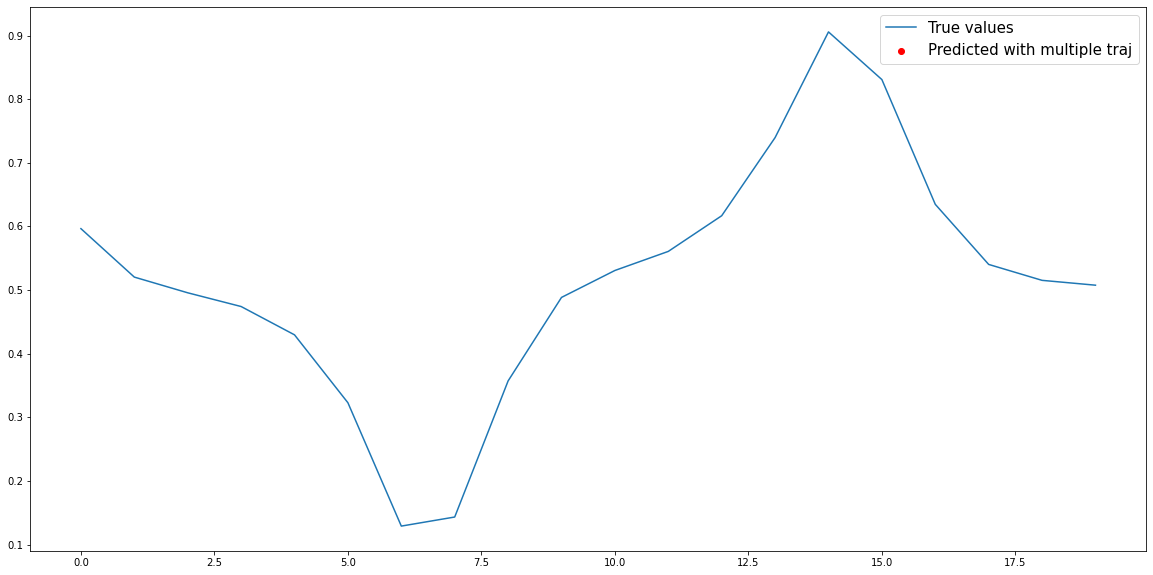

In [61]:
plt.figure(figsize=(20,10))
plt.scatter(np.arange(20), [i if i != 'N' else np.nan for i in unified[144]], color='r', label='Predicted with multiple traj')
plt.plot(np.arange(20), y_true[136:156], label='True values')
plt.legend(fontsize=15)

In [62]:
with open('my_pred2.pickle', 'rb') as f:
    mp = pickle.load(f)

In [69]:
mp = [[i[j] for i in mp] for j in range(len(mp[0]))]

In [148]:
unified2 = [PredictTrajectories(f, 0.4, 0.01, 5) for f in mp]

C:\Users\glady\anaconda3\lib\site-packages\dbscan1d\core.py:37: RuntimeWarning: invalid value encountered in greater
  gt_eps = abs(cores - np.roll(cores, 1)) > self.eps
C:\Users\glady\anaconda3\lib\site-packages\dbscan1d\core.py:72: RuntimeWarning: invalid value encountered in less_equal
  is_connected = min_vals <= self.eps


In [81]:
unified2

[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.44212423513796484],
 [nan, nan, nan, nan, nan, nan, nan, nan, 0.31072458873277203, nan],
 [nan, nan, nan, nan, nan, nan, nan, 0.3072184361979215, nan, nan],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, 'N'],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.4051517413081206],
 [nan, nan, nan, nan, nan, nan, 0.19787939800795204, nan, nan, nan],
 [nan, nan, 0.235735699187897, nan, nan, nan, nan, nan, nan, nan],
 [nan, 0.23375069962777417, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan,
  nan,
  nan,
  0.19695932418171402,
  nan,
  0.14075066547248263,
  nan,
  nan,
  nan,
  nan],
 [0.543474233644395,
  nan,
  0.19711109139311492,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [nan,
  0.1939657003268592,
  nan,
  0.143681469662

C:\Users\glady\anaconda3\lib\site-packages\dbscan1d\core.py:37: RuntimeWarning: invalid value encountered in greater
  gt_eps = abs(cores - np.roll(cores, 1)) > self.eps
C:\Users\glady\anaconda3\lib\site-packages\dbscan1d\core.py:72: RuntimeWarning: invalid value encountered in less_equal
  is_connected = min_vals <= self.eps


Text(0.5, 1.0, 'Electricity_series_10_steps_ahead_30_trajectories')

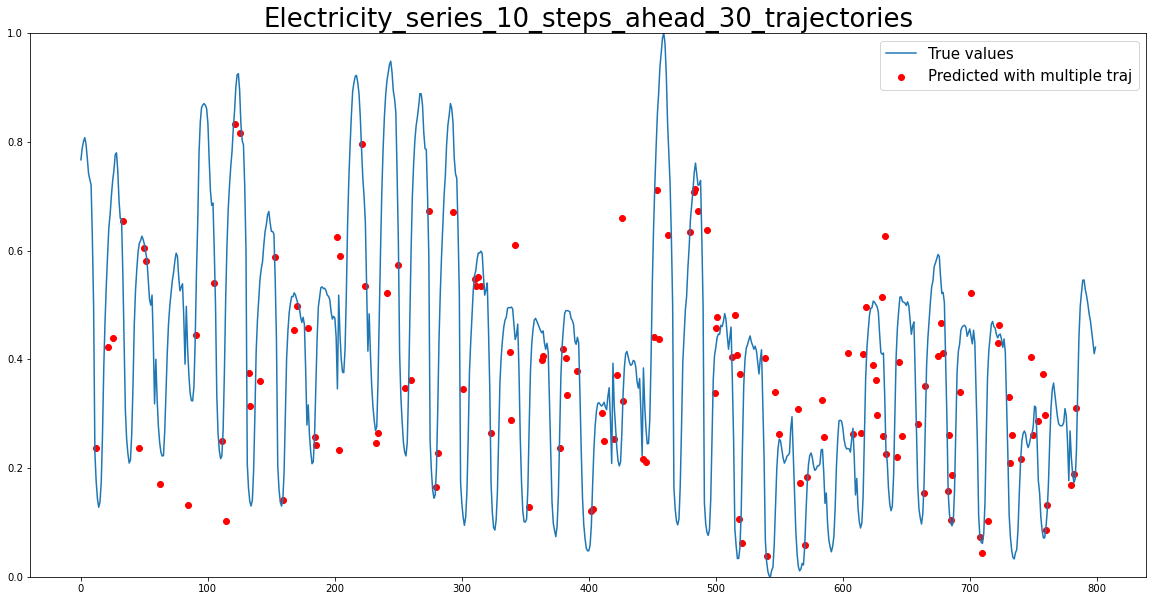

In [197]:
unified2 = [PredictTrajectories(f, 0.2, 0.004, 5) for f in mp]
arrr = np.concatenate(*[unified2[::10]])
abr = [i if i != 'nan' and i != 'N' else np.nan for i in arrr]
plt.figure(figsize=(20,10))
plt.scatter(np.arange(800), abr, color='r', label='Predicted with multiple traj')
plt.plot(np.arange(800), el_test[:800], label='True values')
plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.title('Electricity_series_10_steps_ahead_30_trajectories', fontsize=26)

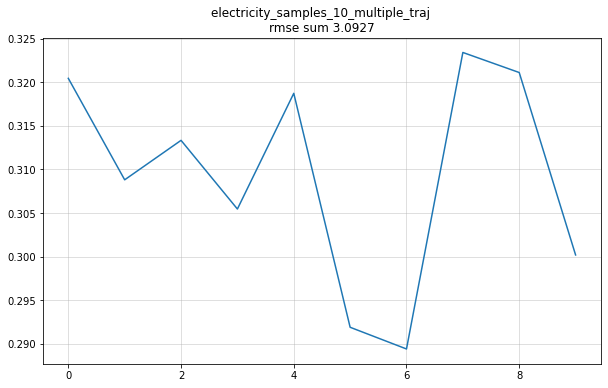

3.0927411416145647


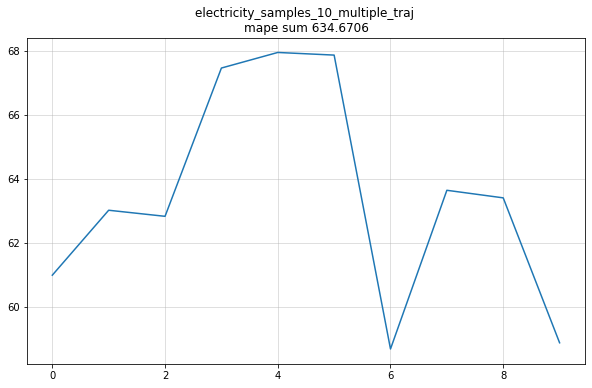

634.6706490187013


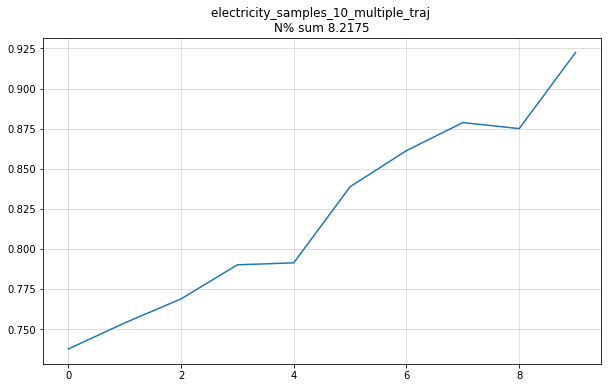

8.2175


In [186]:
plot_metrics(params4, 'electricity_samples_10_multiple_traj')

In [163]:
def parameters_function1(p, tr, h):
    ###########
    ### k goes from 1 to 10
    def get_h_p(p,k):
        v = []
        for i in range(len(p)):
            try:
                v.append(p[i][k - 1])
            except IndexError:
                pass
        return v
    #############
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #############
    pred_all = [list(zip(get_h_p(tr,i),get_h_p(p,i))) for i in range(1, h + 1)]
    rmse_dem = []
    mape_dem = []
    N_score = []
    for i in range(len(pred_all)):
        metric = []
        N_ = 0
        for y in pred_all[i]:
            if 'N' in y:
                N_ += 1
            else:
                metric.append([y[0],y[1]])
        N_ = N_ / len(pred_all[i])
        metric = np.array(metric)
        if metric.size > 0:
            if len(metric) > 1:
                score_rmse = mean_squared_error(np.float_(metric[:,0]), np.float_(metric[:,1]), squared=False)
                score_mape = mean_absolute_percentage_error(np.float_(metric[:,0]), np.float_(metric[:,1]))
                rmse_dem.append(score_rmse)
                mape_dem.append(score_mape)
                N_score.append(N_)
        else:
            rmse_dem.append(np.nan)
            mape_dem.append(np.nan)
            N_score.append(1)
     
    return rmse_dem, mape_dem, N_score, pred_all

In [164]:
def plot_metrics(params, name):
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[0])
    plt.title(f'{name} \n' + 'rmse sum' +' '+ str(f'{sum(params4[0]):.4f}'))
    plt.show()
    print(sum(params[0]))
    
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[1])
    plt.title(f'{name} \n' + 'mape sum' +' '+ str(f'{sum(params4[1]):.4f}'))
    plt.show()
    print(sum(params[1]))
    
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[2])
    plt.title(f'{name} \n' + 'N% sum' +' '+  str(f'{sum(params4[2]):.4f}'))
    plt.show()
    print(sum(params[2]))

In [167]:
len(unified2)

800

In [165]:
tr = [y_true[i: i + 10].tolist() for i in range(800)]

In [179]:
np.isnan('N')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [182]:
cleared = [[x if x == 'N' or not np.isnan(x) else 'N' for x in y] for y in unified2]

In [183]:
cleared

[['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 0.4430954143294752],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 0.31150808348939013, 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 0.3072535130500334, 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 0.40503131693025446],
 ['N', 'N', 'N', 'N', 'N', 'N', 0.19864122581011448, 'N', 'N', 'N'],
 ['N', 'N', 0.23724653743755772, 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 0.23080357669369897, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N',
  'N',
  'N',
  0.19000671700521393,
  'N',
  0.141659501896984,
  'N',
  'N',
  'N',
  'N'],
 [0.5470944184093204,
  'N',
  0.20199840906614439,
  'N',
  0.14218411791891222,
  'N',
  'N',
  'N',
  'N',
  'N'],
 ['N',
  0.18724398125642894,
  'N'

In [184]:
params4 = parameters_function1(cleared, tr, 10)

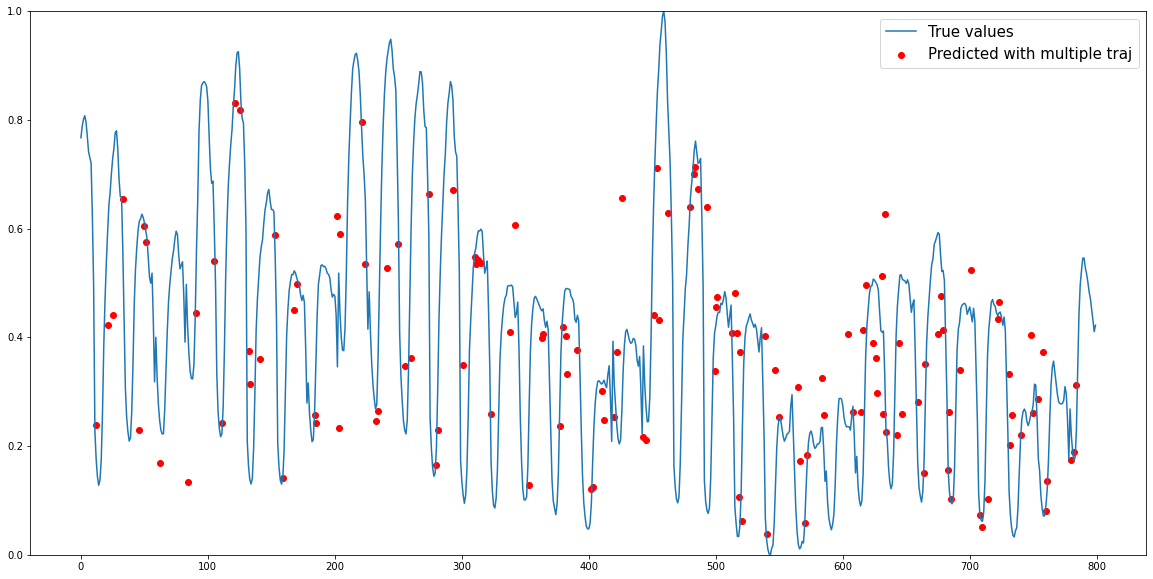

In [160]:
plt.figure(figsize=(20,10))
plt.scatter(np.arange(800), abr, color='r', label='Predicted with multiple traj')
plt.plot(np.arange(800), el_test[:800], label='True values')
plt.ylim(0, 1)
plt.legend(fontsize=15)

In [149]:
arrr = np.concatenate(*[unified2[::10]])

TypeError: 'value' must be an instance of str or bytes, not a float

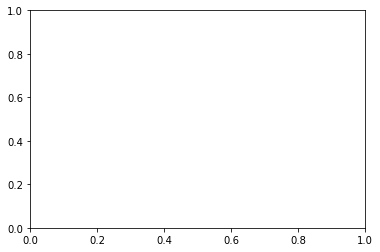

In [129]:
plt.scatter(np.arange(800), [i if i != 'N' else np.nan for i in np.concatenate(*[unified2[::10]])])

In [133]:
arrr[0] == 'nan'

True

In [150]:
abr = [i if i != 'nan' and i != 'N' else np.nan for i in arrr]

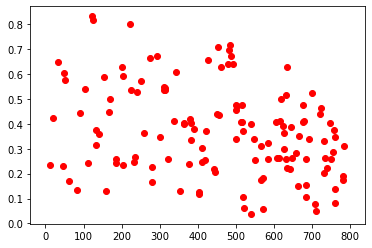

In [151]:
plt.scatter(np.arange(800), abr, color='r', label='Predicted with multiple traj')

In [145]:
abr

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.235735699187897',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.4243059676393618',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.6497261042084053',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.23094092462657995',
 nan,
 nan,
 nan,
 '0.6044452103659173',
 '0.5756342245150735',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.16998245690380767',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.13410958804921785',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.4427660160840657',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.5382945581606144',
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.24115092665092924',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '0.8302999512827139',
 nan,
 nan,
 nan,
 '0.8147568035527958',
 nan,
 nan,
 nan,
 n